In [1]:
# Created during May 25 HACKATHON by JD

# Calculates win percentage given on game score for both players.

In [2]:
from copy import deepcopy
import csv
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_files = [
    '/home/cesar/data/autogenerated-data/20220823/autogenerate_20220823_autoplay_5.csv',   # a CSW21 set
    '/home/cesar/data/autogenerated-data/20220824/autogenerate_20220825_autoplay_3.csv']   # a NWL20 set

todays_date = date.today().strftime("%Y%m%d")
pd.options.display.max_rows = 999

In [3]:
spread = {}
win_dict = {}

t0 = time.time()

# because moves are logged chronologically, we can overwrite the entry for each game ID
# for each move until we reach the final move, at which point we know the final state of the game.
for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            if i<10:
                print(row)

            # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
            if row[0]=='p1':
                spread[row[1]] = int(row[6])-int(row[11])
            else:
                spread[row[1]] = int(row[11])-int(row[6])

['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
['p2', '6305d312010f678f3a000001', '2', 'ACHINOZ', ' F4 HOAC.ZIN', '76', '76', '7', '', '76.000', '80', '30']
['p2', '6305d312010f678f

Processed 27000000 rows in 106.97619533538818 seconds
Processed 28000000 rows in 107.91488671302795 seconds
Processed 29000000 rows in 108.82599472999573 seconds
Processed 30000000 rows in 109.7497763633728 seconds
Processed 31000000 rows in 110.67312979698181 seconds
Processed 32000000 rows in 111.64334416389465 seconds
Processed 33000000 rows in 112.56669664382935 seconds
Processed 34000000 rows in 113.5002555847168 seconds
Processed 35000000 rows in 114.41567826271057 seconds
Processed 36000000 rows in 115.33816075325012 seconds
Processed 37000000 rows in 116.386962890625 seconds
Processed 38000000 rows in 117.30843019485474 seconds
Processed 39000000 rows in 118.26498985290527 seconds
Processed 40000000 rows in 119.20256185531616 seconds
Processed 41000000 rows in 120.12201380729675 seconds
Processed 42000000 rows in 121.03684592247009 seconds
Processed 43000000 rows in 121.99428153038025 seconds
Processed 44000000 rows in 122.9456582069397 seconds
Processed 45000000 rows in 123.87

In [4]:
for game_id in spread.keys():
    win_dict[game_id] = (np.sign(spread[game_id])+1)/2

Can define what spread beyond which you assume player has a 0 or 100% chance of winning - using 300 as first guess.

Also, spreads now range only from 0 to positive numbers, because trailing by 50 and winning is the same outcome and leading by 50 and losing (just swapping the players' perspectives)

In [5]:
max_spread = 200
counter_dict_by_spread_and_tiles_remaining = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}
win_counter_dict_by_spread_and_tiles_remaining = deepcopy(counter_dict_by_spread_and_tiles_remaining)

In [6]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            # truncate spread to the range -max_spread to max_spread
            end_of_turn_tiles_left = int(row[10])-int(row[7])
            end_of_turn_spread = min(max(int(row[6])-int(row[11]),-max_spread),max_spread)

            if end_of_turn_tiles_left >= 0:
                counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread] += 1

                if row[0]=='p1':
                    win_counter_dict_by_spread_and_tiles_remaining[
                        end_of_turn_tiles_left][end_of_turn_spread] += win_dict[row[1]]
                else:
                    win_counter_dict_by_spread_and_tiles_remaining[
                        end_of_turn_tiles_left][end_of_turn_spread] += (1-win_dict[row[1]])

        # debug rows
#         if i<10:
#             print(row)
#             print(end_of_turn_spread)
#             print(end_of_turn_tiles_left)
#             print(counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread])
#             print(win_counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread])

There are 8000000 games
Processed 1000000 rows in 1.3949394226074219 seconds
Processed 2000000 rows in 2.7743961811065674 seconds
Processed 3000000 rows in 4.16496729850769 seconds
Processed 4000000 rows in 5.5635597705841064 seconds
Processed 5000000 rows in 6.954536437988281 seconds
Processed 6000000 rows in 8.343970775604248 seconds
Processed 7000000 rows in 9.806049346923828 seconds
Processed 8000000 rows in 11.248051404953003 seconds
Processed 9000000 rows in 12.660759925842285 seconds
Processed 10000000 rows in 14.07196593284607 seconds
Processed 11000000 rows in 15.463362693786621 seconds
Processed 12000000 rows in 16.868635177612305 seconds
Processed 13000000 rows in 18.26229500770569 seconds
Processed 14000000 rows in 19.649030923843384 seconds
Processed 15000000 rows in 21.051218271255493 seconds
Processed 16000000 rows in 22.483723640441895 seconds
Processed 17000000 rows in 23.88052773475647 seconds
Processed 18000000 rows in 25.301405668258667 seconds
Processed 19000000 ro

Processed 67000000 rows in 224.29510498046875 seconds
Processed 68000000 rows in 225.71716499328613 seconds
Processed 69000000 rows in 227.13872814178467 seconds
Processed 70000000 rows in 228.56251049041748 seconds
Processed 71000000 rows in 229.982839345932 seconds
Processed 72000000 rows in 231.40715050697327 seconds
Processed 73000000 rows in 232.82443404197693 seconds
Processed 74000000 rows in 234.2474970817566 seconds
Processed 75000000 rows in 235.69484329223633 seconds
Processed 76000000 rows in 237.14878582954407 seconds
Processed 77000000 rows in 238.60821866989136 seconds
Processed 78000000 rows in 240.14791464805603 seconds
Processed 79000000 rows in 241.625305891037 seconds
Processed 80000000 rows in 243.1136829853058 seconds
Processed 81000000 rows in 244.57725024223328 seconds
Processed 82000000 rows in 246.02717804908752 seconds
Processed 83000000 rows in 247.48827624320984 seconds
Processed 84000000 rows in 248.98661541938782 seconds
Processed 85000000 rows in 250.475

In [7]:
count_df = pd.DataFrame(counter_dict_by_spread_and_tiles_remaining)
win_df = pd.DataFrame(win_counter_dict_by_spread_and_tiles_remaining)
win_pct_df = (win_df/count_df)

def mapfn(p):
    if p == 0:
        p = 0.0001
    if p == 1:
        p = 0.9999
    return np.log(p/(1-p))

# "stretch out" the distribution by applying a logit transformation
logit_df = win_pct_df.applymap(mapfn)

Text(0.5, 1.0, 'log-odds by tiles remaining and spread')

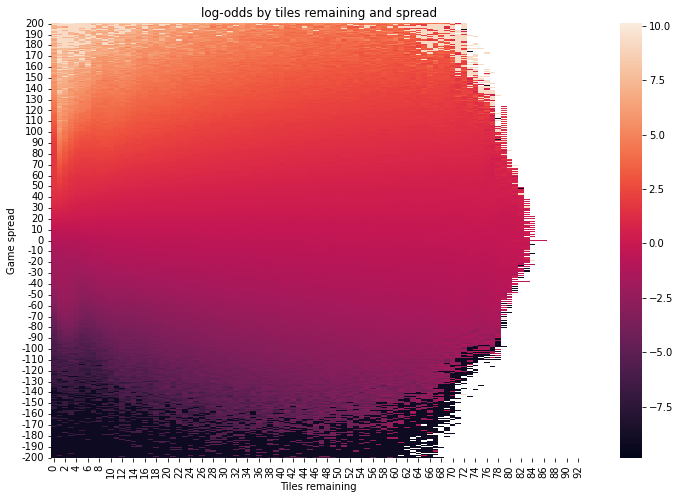

In [8]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(logit_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('log-odds by tiles remaining and spread')

In [9]:
logit_df[1][100]  # tiles remaining, 100 game spread:

5.389240834408084

#### Remove outliers by assigning to each "pixel" the average of itself and its eight neighbors, removing the highest and lowest value

In [10]:
averaged_copy = logit_df.copy()

def average_around(df, i1, i2):
    s = 0
    ct = 0
    vals = []
    for x in (i1-1, i1, i1+1):
        for y in (i2-1, i2, i2+1):
#             if x == i1 and y == i2:
#                 pass
            try:
                vals.append(df[x][y])
                s += df[x][y]
                ct += 1
            except KeyError:
                continue
    if ct > 2:  # Remove outliers from averaging.
        s -= max(vals)
        s -= min(vals)
        
        ct -= 2
    return s / ct


for row in logit_df.itertuples():  # one row for each spread
    spread = row.Index
    last_known_val = -1
    for idx, w in enumerate(row[1:]):  # idx here is tiles remaining
        avg = average_around(logit_df, idx, row.Index)
        if np.isnan(avg):
            averaged_copy[idx][row.Index] = last_known_val
        else:
            last_known_val = avg
            averaged_copy[idx][row.Index] = avg
        
        

Text(0.5, 1.0, 'averaged log-odds by tiles remaining and spread')

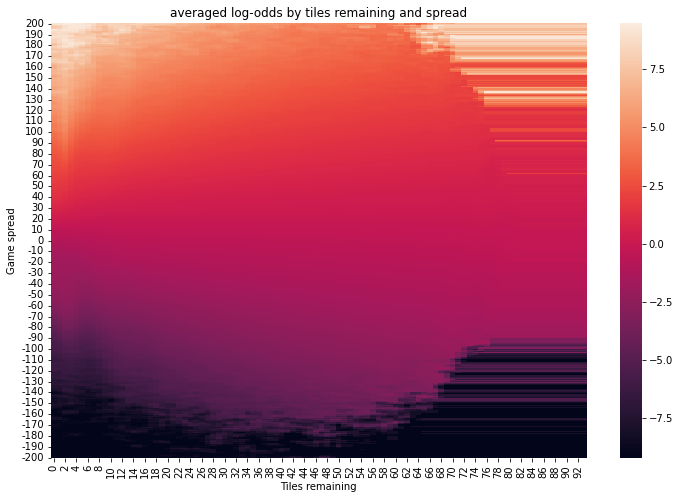

In [11]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(averaged_copy, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('averaged log-odds by tiles remaining and spread')

In [12]:
def logisticfn(p):
    return np.exp(p) / (np.exp(p) + 1)

# convert back to win probability.
smoothed_winpct_df = averaged_copy.applymap(logisticfn)

Text(0.5, 1.0, 'Unsmoothed win pct by tiles remaining and spread')

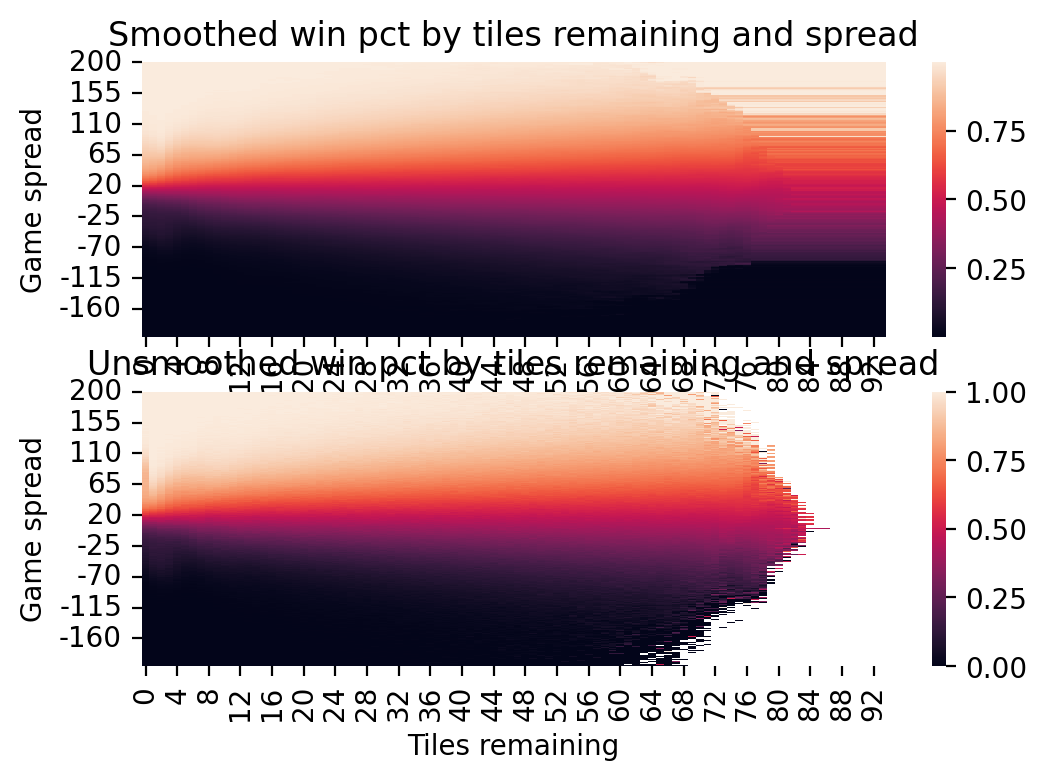

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_dpi(200)
sns.heatmap(smoothed_winpct_df, ax=ax1)
ax1.set_ylabel('Game spread')
ax1.set_title('Smoothed win pct by tiles remaining and spread')

sns.heatmap(win_pct_df, ax=ax2)
ax2.set_xlabel('Tiles remaining')
ax2.set_ylabel('Game spread')
ax2.set_title('Unsmoothed win pct by tiles remaining and spread')

In [14]:
# Fill in missing data.

# Export smoothed win pct 
smoothed_winpct_df.to_csv('smoothed_winpct.csv')

## Everything below this cell seems experimental

In [ ]:
plt.savefig('win_pct.jpg')

In [ ]:
count_df.iloc[300:350,79:]

The 50% win line is likely a little bit above 0 spread, because when you end a turn with 0 spread, your opponent on average gets an extra half-turn more than you for the rest of the game. Let's find that line.

In [ ]:
win_pct_df.iloc[250:350,79:]

## Opening turn scores

In [ ]:
pd.options.display.max_rows = 999

## Apply smoothing
We want the win percentage to increase monotonically with spread, even though we have a limited sample size and this may not always be true. Therefore, we want to be able to average win percentages over neighboring scenarios (similar spread difference and similar # of tiles remaining).

In [ ]:
counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
win_counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
rows = []

In [ ]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        if row[2]=='1':
            counter_dict_by_opening_turn_score[int(row[5])] += 1
            
            # check which player went first
            if row[0]=='p1':
                win_counter_dict_by_opening_turn_score[int(row[5])] += win_dict[row[1]]
                rows.append([int(row[5]), win_dict[row[1]]])
            else:
                win_counter_dict_by_opening_turn_score[int(row[5])] += 1-win_dict[row[1]]
                rows.append([int(row[5]), 1-win_dict[row[1]]])

        
#         # debug rows
#         if i<10:
#             print(row)

In [ ]:
tst_df=pd.DataFrame(rows).rename(columns={0:'opening turn score',1:'win'})

In [ ]:
opening_turn_count = pd.Series(counter_dict_by_opening_turn_score)
opening_turn_win_count = pd.Series(win_counter_dict_by_opening_turn_score)
opening_turn_win_pct = opening_turn_win_count/opening_turn_count

In [ ]:
tst = opening_turn_win_pct.dropna()

In [ ]:
opening_turn_win_pct

In [ ]:
fig,ax=plt.subplots()
plt.plot(tst)
plt.savefig('plot1.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax)
plt.savefig('regression_plot.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax,fit_reg=False)
plt.savefig('regression_plot_no_fitline.png')